In [17]:
import pandas as pd
import json
import numpy as np
from src.data_utils import load_xsum_dict
import matplotlib.pyplot as plt
import seaborn as sns

xsum_test = load_xsum_dict("test")

def read_logs(path):
    iteration_logs = json.load(open(path, "r"))

    data = []
    edits_by_sum_id = {}
    for iteration in iteration_logs:
        result_obj = {
            "iteration": iteration["iteration"],
            "summaries_generated": iteration['summary_generated']
        }
        data.append(result_obj)
    
    return pd.DataFrame(data).set_index("iteration")

def normalize_df(df):
    return df / df.sum()


# dataset = "pegasus"
# dataset = "bart-test-extrinsic-100"
dataset = "bart-full"

# full_iteration_stats = read_logs("results/iteration-changes/bart-full-classifier-knnv1.json")
# oracle_100_iteration_stats = read_logs("results/iteration-changes/bart-test-extrinsic-100-oracle.json")
# knn_100_iteration_stats = read_logs("results/iteration-changes/bart-test-extrinsic-100-classifier-knnv1.json")

full_iteration_stats = read_logs("results/iteration-changes/pegasus-full-classifier-knnv1.json")
oracle_100_iteration_stats = read_logs("results/iteration-changes/pegasus-test-extrinsic-75-oracle.json")
knn_100_iteration_stats = read_logs("results/iteration-changes/pegasus-test-extrinsic-75-classifier-knnv1.json")

print('100-sample oracle')
display(oracle_100_iteration_stats)
print('100-sample knn')
display(knn_100_iteration_stats)
print('full Xsum test (knn)')
display(full_iteration_stats)

experiment_raw_data = {
    'full': full_iteration_stats,
    'oracle-100': oracle_100_iteration_stats,
    'knn-100': knn_100_iteration_stats
}

Using custom data configuration default
Reusing dataset xsum (/Users/daniel/.cache/huggingface/datasets/xsum/default/1.2.0/32c23220eadddb1149b16ed2e9430a05293768cfffbdfd151058697d4c11f934)


  0%|          | 0/3 [00:00<?, ?it/s]

100-sample oracle


,summaries_generated
iteration,
0,100
1,23
2,7
3,5
4,4
5,1


100-sample knn


,summaries_generated
iteration,
0,100
1,46
2,26
3,18
4,12
5,6
6,4
7,3
8,2


full Xsum test (knn)


,summaries_generated
iteration,
0,11334
1,3866
2,2282
3,1403
4,853
5,277
6,104
7,40
8,19


In [18]:
def compute_examples_converged_during_iteration(raw_stats, iteration_stat):
    next_iteration_idx = iteration_stat.name + 1
    try:
        next_iteration_summaries_generated = raw_stats.loc[next_iteration_idx, 'summaries_generated']
    except KeyError:
        next_iteration_summaries_generated = 0

    return iteration_stat['summaries_generated'] - next_iteration_summaries_generated

iteration_convergence_across_experiments = []

for experiment_name, raw_stats in experiment_raw_data.items():

    examples_converged_across_iterations = []
    for index, iteration_stat in raw_stats.iterrows():
        examples_converged = compute_examples_converged_during_iteration(raw_stats, iteration_stat)
        examples_converged_across_iterations.append(examples_converged)

    examples_converged_across_iterations = pd.Series(examples_converged_across_iterations)
    iteration_convergence_across_experiments.append((experiment_name, examples_converged_across_iterations))

iteration_convergence_across_experiments = dict(iteration_convergence_across_experiments)
iteration_convergence_across_experiments.keys()

dict_keys(['full', 'oracle-100', 'knn-100'])

In [19]:
foo = normalize_df(pd.DataFrame(iteration_convergence_across_experiments['oracle-100'], columns=['examples_converged'])).reset_index()
foo['system'] = 'oracle'
foo = foo.rename(columns={'index': 'iteration_index'})
bar = normalize_df(pd.DataFrame(iteration_convergence_across_experiments['knn-100'], columns=['examples_converged'])).reset_index()
bar['system'] = 'knn'
bar = bar.rename(columns={'index': 'iteration_index'})

to_plot = pd.concat([foo, bar]).reset_index().drop(columns=['index'])
to_plot

,iteration_index,examples_converged,system
0,0,0.77,oracle
1,1,0.16,oracle
2,2,0.02,oracle
3,3,0.01,oracle
4,4,0.03,oracle
5,5,0.01,oracle
6,0,0.54,knn
7,1,0.20,knn
8,2,0.08,knn
9,3,0.06,knn


Text(0.5, 1.0, 'Convergence over Iterations (N = 100)')

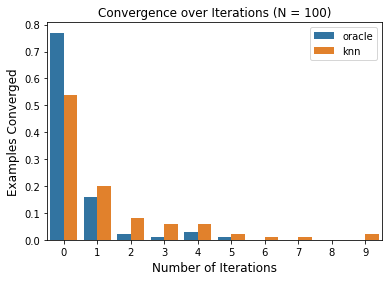

In [20]:
# plt.figure(figsize = (6,2))
plt.figure()
ax = sns.barplot(data=to_plot, x='iteration_index', y='examples_converged', hue='system')
ax.set_xlabel("Number of Iterations", fontsize=12)
ax.set_ylabel('Examples Converged', fontsize=12)
ax.legend(loc='upper right')
ax.set_title('Convergence over Iterations (N = 100)', fontsize=12)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'Convergence over Iterations (N = 100)')

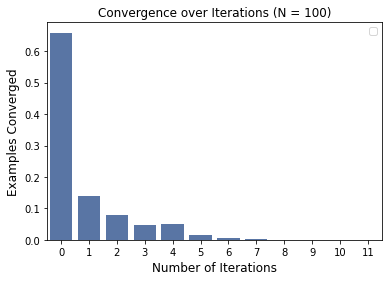

In [21]:
# plt.figure(figsize = (6,2))
plt.figure()
ax = sns.barplot(
    data=normalize_df(pd.DataFrame(iteration_convergence_across_experiments['full'])).reset_index(),
    x='index',
    y=0,
    color='#4c72b0'
)
ax.set_xlabel("Number of Iterations", fontsize=12)
ax.set_ylabel('Examples Converged', fontsize=12)
ax.legend(loc='upper right')
ax.set_title('Convergence over Iterations (N = 100)', fontsize=12)

In [22]:
baz = normalize_df(pd.DataFrame(iteration_convergence_across_experiments['full'], columns=['examples_converged'])).reset_index()
baz['system'] = 'knn-full'
baz = baz.rename(columns={'index': 'iteration_index'})

to_plot_all = pd.concat([to_plot, baz]).reset_index().drop(columns=['index'])

to_plot_all

to_plot_all['number_of_iterations_ran'] = to_plot_all['iteration_index'] + 1
to_plot_all

,iteration_index,examples_converged,system,number_of_iterations_ran
0,0,0.770000,oracle,1
1,1,0.160000,oracle,2
2,2,0.020000,oracle,3
3,3,0.010000,oracle,4
4,4,0.030000,oracle,5
5,5,0.010000,oracle,6
6,0,0.540000,knn,1
7,1,0.200000,knn,2
8,2,0.080000,knn,3
9,3,0.060000,knn,4


Text(0.5, 1.0, 'Convergence over Iterations for PEGASUS GEF')

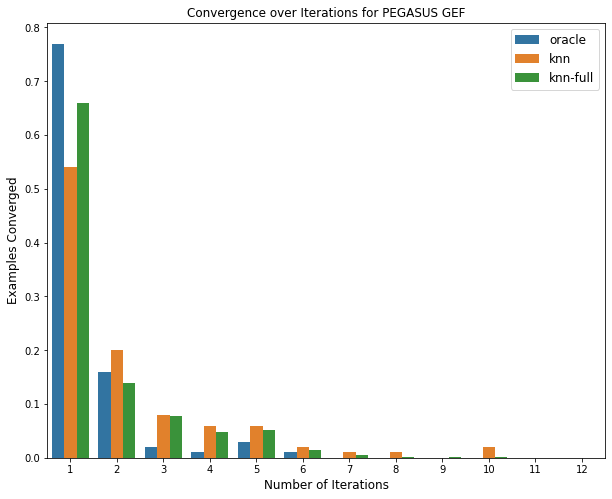

In [23]:
plt.figure(figsize = (10, 8))
ax = sns.barplot(data=to_plot_all, x='number_of_iterations_ran', y='examples_converged', hue='system')
ax.set_xlabel("Number of Iterations", fontsize=12)
ax.set_ylabel('Examples Converged', fontsize=12)
ax.legend(loc='upper right', fontsize=12)
ax.set_title('Convergence over Iterations for PEGASUS GEF', fontsize=12)

Text(0.5, 1.0, 'Convergence over Iterations for BART GEF')

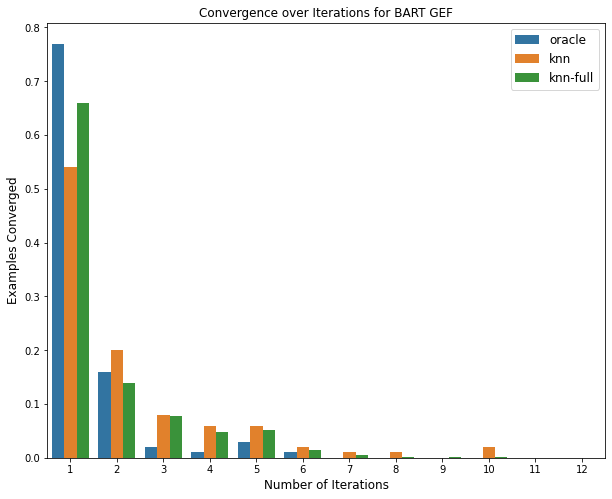

In [24]:
plt.figure(figsize = (10, 8))
ax = sns.barplot(data=to_plot_all, x='number_of_iterations_ran', y='examples_converged', hue='system')
ax.set_xlabel("Number of Iterations", fontsize=12)
ax.set_ylabel('Examples Converged', fontsize=12)
ax.legend(loc='upper right', fontsize=12)
ax.set_title('Convergence over Iterations for BART GEF', fontsize=12)

In [107]:
to_plot_all.groupby('system').describe()

iteration_index                                             \
                   count mean       std  min   25%  50%   75%   max   
system                                                                
knn                 12.0  5.5  3.605551  0.0  2.75  5.5  8.25  11.0   
knn-full            13.0  6.0  3.894440  0.0  3.00  6.0  9.00  12.0   
oracle               8.0  3.5  2.449490  0.0  1.75  3.5  5.25   7.0   

         examples_converged            ...                      \
                      count      mean  ...       75%       max   
system                                 ...                       
knn                    12.0  0.083333  ...  0.102500  0.480000   
knn-full               13.0  0.076923  ...  0.059202  0.672225   
oracle                  8.0  0.125000  ...  0.137500  0.480000   

         number_of_iterations_ran                                              
                            count mean       std  min   25%  50%    75%   max  
system                                                                         
knn                          12.0  6.5  3.605551  1.0  3.75  6.5   9.25  12.0  
knn-full                     13.0  7.0  3.894440  1.0  4.00  7.0  10.00  13.0  
oracle                        8.0  4.5  2.449490  1.0  2.75  4.5   6.25   8.0  

[3 rows x 24 columns]

In [36]:
from scipy import stats
iteration_convergence_frequency_by_iteration = dict

for name, counts in iteration_convergence_across_experiments.items():
    frequencies_by_iteration = counts / counts.sum()
    xk = frequencies_by_iteration.index
    distrib = stats.rv_discrete(name=name, values=(frequencies_by_iteration.index, frequencies_by_iteration.values))
    print(f"{name}: {distrib.mean()} ± {distrib.std()}")


full: 0.7818951826363155 ± 1.3782846898895973
oracle-100: 0.39999999999999997 ± 0.9486832980505139
knn-100: 1.19 ± 1.890476130502578


In [26]:
iteration_convergence_across_experiments

{'full': 0     7468
 1     1584
 2      879
 3      550
 4      576
 5      173
 6       64
 7       21
 8        7
 9        7
 10       4
 11       1
 dtype: int64,
 'oracle-100': 0    77
 1    16
 2     2
 3     1
 4     3
 5     1
 dtype: int64,
 'knn-100': 0    54
 1    20
 2     8
 3     6
 4     6
 5     2
 6     1
 7     1
 8     0
 9     2
 dtype: int64}